<a href="https://colab.research.google.com/github/Dimildizio/DS_course/blob/main/Neural_networks/Transfer_learning/TVshow_characters_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons characters classification

## Install libs

In [ ]:
!pip install kaggle

## imports

In [29]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

### Create folder and download the dataset

If you want to follow this track, don't forget to put **your** kaggle API (download kaggle.json from kaggle.com) in the current dirrectory (I assume its 'content' for you)

In [6]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c journey-springfield
!unzip -q journey-springfield.zip

If you cannot perform the actions above or you don't have kaggle account (what are you doing here then?) - uncomment and use the code below. Of course you need to mound the drive and upload your version of dataset

In [7]:
#from google.colab import drive
#drive.mount('/content/gdrive/')
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

### Sort data in order and get labels

In [12]:
path_train = Path('./train/')
path_test = Path('./testset/')

train_val_files = sorted(list(path_train.rglob('*.jpg')))
test_files = sorted(list(path_test.rglob('*.jpg')))

train_val_labels = [path.parent.name for path in train_val_files]

### Split train labels into train and val data with stratification

In [15]:
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

## Load images as Datasets

In [24]:
RESCALE_SIZE = 224
IMAGENET_MEANS = [0.485, 0.456, 0.406]
IMAGENET_STDS =  [0.229, 0.224, 0.225]

In [31]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow for tensors"""
    inp = np.array(IMAGENET_STDS) * inp.numpy().transpose((1, 2, 0)) + np.array(IMAGENET_MEANS)
    inp = np.clip(inp, 0, 1)

    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [72]:
class CustomDataset(Dataset):
  def __init__(self, files, train=True):
    super().__init__()
    self.files = sorted(files)
    self.le = LabelEncoder()
    self.train_mode = train
    if train:
      self.labels = self.l_encode

  def __len__(self):
    return len(self.files)

  def __getitem__(self, idx):
    filename = self.files[idx]
    img = self._load_sample(filename)
    img = np.array(img/255, dtype='float32')
    img = self._get_transform(img)
    return self._get_xy(img, idx)

  @staticmethod
  def _load_sample(name):
    img = Image.open(name)
    img.load()
    img = img.resize((RESCALE_SIZE, RESCALE_SIZE))
    return np.array(img)

  @property
  def l_encode(self):
    labels = [path.parent.name for path in self.files]
    self.le.fit(labels)
    with open('le.pkl', 'wb') as f:
      pickle.dump(self.le, f)
    return labels

  def _get_xy(self, x, y_idx):
    if self.train_mode:
      label = self.labels[y_idx]
      label_id = self.le.transform([label])
      return x, label_id.item()
    else:
      return x

  @staticmethod
  def _get_transform(img):
    transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(IMAGENET_MEANS,
                                                        IMAGENET_STDS)])
    return transform(img)



In [73]:
val_dataset = CustomDataset(val_files)

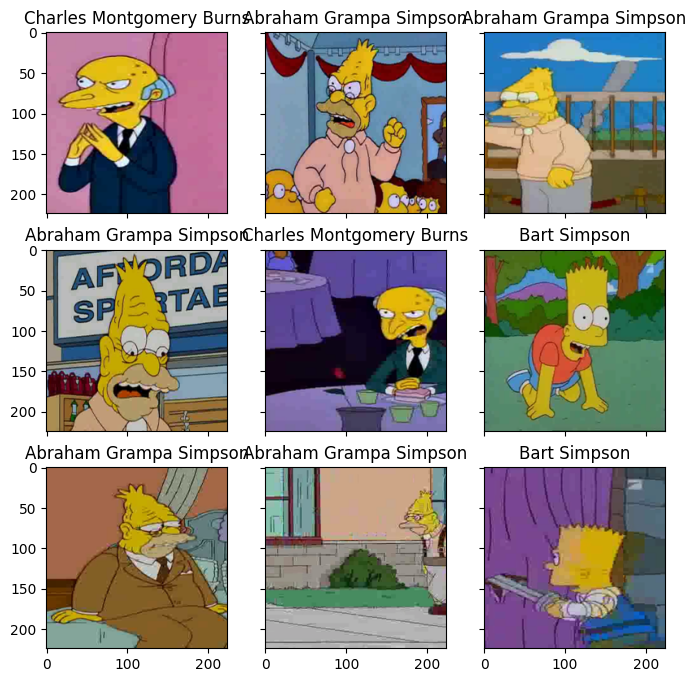

In [78]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.le.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)